<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB
None
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695   

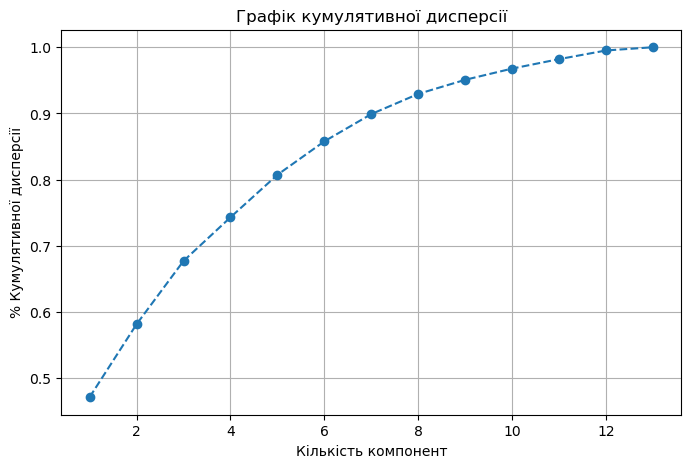

Компонента 1: Власне значення = 0.4713, Кумулятивна дисперсія = 0.4713
Компонента 2: Власне значення = 0.1103, Кумулятивна дисперсія = 0.5815
Компонента 3: Власне значення = 0.0956, Кумулятивна дисперсія = 0.6771
Компонента 4: Власне значення = 0.0660, Кумулятивна дисперсія = 0.7431
Компонента 5: Власне значення = 0.0642, Кумулятивна дисперсія = 0.8073
Компонента 6: Власне значення = 0.0506, Кумулятивна дисперсія = 0.8579
Компонента 7: Власне значення = 0.0412, Кумулятивна дисперсія = 0.8991
Компонента 8: Власне значення = 0.0305, Кумулятивна дисперсія = 0.9295
Компонента 9: Власне значення = 0.0213, Кумулятивна дисперсія = 0.9508
Компонента 10: Власне значення = 0.0169, Кумулятивна дисперсія = 0.9678
Компонента 11: Власне значення = 0.0143, Кумулятивна дисперсія = 0.9821
Компонента 12: Власне значення = 0.0130, Кумулятивна дисперсія = 0.9951
Компонента 13: Власне значення = 0.0049, Кумулятивна дисперсія = 1.0000
Оптимальна кількість компонент: 9
[Класична модель без PCA]:
            

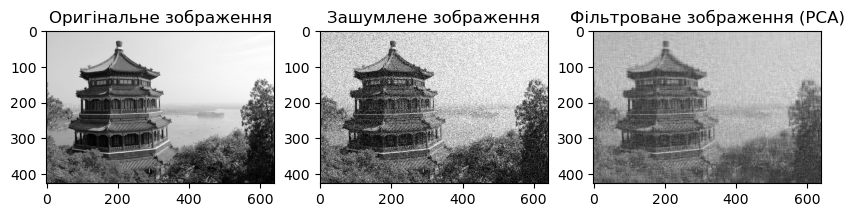

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import load_sample_image
from skimage.color import rgb2gray
from skimage.restoration import denoise_wavelet

# 1. Завантаження власних даних
df = pd.read_csv("boston.csv")
print(df.info())
print(df.describe())

# Видалення нечислових стовпців
df = df.select_dtypes(include=[np.number])

# 2. Масштабування даних
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(columns=['MEDV']))  # Відкидаємо цільову змінну

# 3. Застосування PCA
pca = PCA()
pca_transformed = pca.fit_transform(df_scaled)

# 4. Аналіз отриманих результатів
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel("Кількість компонент")
plt.ylabel("% Кумулятивної дисперсії")
plt.title("Графік кумулятивної дисперсії")
plt.grid()
plt.show()

# 5. Вивід характеристик PCA
for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
    print(f"Компонента {i+1}: Власне значення = {var:.4f}, Кумулятивна дисперсія = {cum_var:.4f}")

# 6. Визначення оптимальної кількості головних компонент
optimal_components = np.argmax(cumulative_variance >= 0.95) + 1  # Вибираємо компоненти, які пояснюють 95% дисперсії
print(f"Оптимальна кількість компонент: {optimal_components}")

# 7. Готуємо вхідні та вихідні дані для класифікації
X = df_scaled
y = df['MEDV'] > df['MEDV'].median()  # Робимо з MEDV бінарну змінну: 1 — якщо ціна > медіани, інакше 0

# 8. Ділимо на тренувальний і тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("[Класична модель без PCA]:")
print(classification_report(y_test, y_pred))

# Застосування PCA до класифікаційної моделі (Пункти 8–10)
pca = PCA(n_components=optimal_components)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

print("\n[8] Застосування PCA до підготовленого датасету:")
print(f"Розмірність до PCA: {X_train.shape}")
print(f"Розмірність після PCA: {X_pca_train.shape}")

clf_pca = RandomForestClassifier(random_state=42)

print("\n[9] Навчання моделі на PCA-ознаках...")
clf_pca.fit(X_pca_train, y_train)
y_pca_pred = clf_pca.predict(X_pca_test)

print("\n[10] Оцінка моделі, побудованої на PCA-даних:")
print(classification_report(y_test, y_pca_pred))


# 11. Створюємо конвеєр (pipeline) — поєднуємо масштабування, PCA і модель в одну послідовність
from sklearn.pipeline import Pipeline
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),                      # Масштабуємо дані
    ('pca', PCA(n_components=optimal_components)),     # Застосовуємо PCA
    ('classifier', RandomForestClassifier(random_state=42))  # Класифікаційна модель
])
pca_pipeline.fit(X_train, y_train)
y_pipe_pred = pca_pipeline.predict(X_test)
print("Модель з PCA у конвеєрі:")
print(classification_report(y_test, y_pipe_pred))

# 12. Застосування PCA до зображення
image = load_sample_image("china.jpg")
gray_image = rgb2gray(image)  # Перетворюємо в чорно-біле

# Додаємо шум до зображення
noisy_image = gray_image + 0.2 * np.random.normal(size=gray_image.shape)
noisy_image = np.clip(noisy_image, 0, 1)  # Обмежуємо значення в межах [0, 1]

# Використовуємо PCA для "очищення" зображення (відновлення з 50 компонент)
image_pca = PCA(n_components=50)
compressed = image_pca.fit_transform(noisy_image)
denosed_image = image_pca.inverse_transform(compressed)

# Виводимо результат
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Оригінальне зображення')

plt.subplot(1, 3, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title('Зашумлене зображення')

plt.subplot(1, 3, 3)
plt.imshow(denosed_image, cmap='gray')
plt.title('Фільтроване зображення (PCA)')
plt.show()

